In [1]:
#Import libraries and functions

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import glob #pattern package to find filename
from skimage.io import imread
from scipy import ndimage
from scipy.ndimage import shift
from scipy.ndimage.measurements import center_of_mass
from scipy.ndimage.interpolation import rotate
from scipy.optimize import curve_fit

In [2]:
#Some constants

kb = 8.62e-2 #in units of meV/K

In [3]:
#Material-specific lattice parameters (in angstrom)

a = 4.29
c = 40.56

lattice_para = np.array([[a*np.cos(0), a*np.sin(0), 0], \
                         [a*np.cos(2*np.pi/3), a*np.sin(2*np.pi/3), 0], \
                         [0, 0, c]])

ra = 4*np.pi/(np.sqrt(3)*a)
rc = 2*np.pi/c

rec_lattice_para = np.array([[ra*np.cos(np.pi/6), ra*np.sin(np.pi/6), 0], \
                             [ra*np.cos(5*np.pi/6), ra*np.sin(5*np.pi/6), 0], \
                             [0, 0, rc]])


In [4]:
#Defining some functions

##Rotation matrix for an in-plane rotation of x_deg degrees

def rot(x_deg):
    theta = np.radians(x_deg)
    c, s = np.cos(theta), np.sin(theta)
    rot_mat = np.array([[c, -s, 0],[s, c, 0], [0, 0, 1]])
    return rot_mat

##Functions that return Q, K, and q for a given (h, k, l), in units of A^-1

def Q(h, k, l):
    return h*rec_lattice_para[0] + k*rec_lattice_para[1] + l*rec_lattice_para[2]

def K(h, k, l): #effectively draws a Voronoi diagram
    
    d_test = 10 #this will store the minimum norm for comparison (10 is just an arbitrary number)
    m_test = 1 #this will store the integer m corresponding to minimum norm
    n_test = 1 #this will store the integer n corresponding to minimum norm

    for m in [np.rint(h), np.rint(h)-1, np.rint(h)+1]:
        for n in [np.rint(k), np.rint(k)-1, np.rint(k)+1]:
            d = (h - m)**2 + (k - n)**2 - (h - m)*(k - n)
#             d = np.dot([h-m, k-n, h-m], [h-m, k-n, n-k])
            if d < d_test:
                d_test = d
                m_test = m
                n_test = n

    return m_test*rec_lattice_para[0] + n_test*rec_lattice_para[1] + np.rint(l)*rec_lattice_para[2]

#     ##alternative, vectorized approach, but is slower by 2x

#     h_array = np.array([np.rint(h)-1, np.rint(h), np.rint(h)+1])
#     k_array = np.array([np.rint(k)-1, np.rint(k), np.rint(k)+1])
    
#     h_mesh, k_mesh = np.meshgrid(h_array, k_array)   
#     hk_array = np.array([h_mesh.flatten(), k_mesh.flatten()]).T #making array of lattice points around given h, k

#     d2 = (hk_array[:, 0] - h)**2 + (hk_array[:, 1] - k)**2 - (hk_array[:, 0] - h)*(hk_array[:, 1] - k) #distance squared   
#     imin = np.argmin(d2) #index at which distance squared is minimum
    
#     return hk_array[imin, 0]*rec_lattice_para[0] + hk_array[imin, 1]*rec_lattice_para[1] + np.rint(l)*rec_lattice_para[2]
            
def q(h, k, l):
    return Q(h, k, l) - K(h, k, l) 

##Bringing arbitrary q into irreducible Brillouin zone as defined in notes, and the rotation angle needed

def q_ibz(h, k, l):
    qtemp = q(h, k, l)   
    count = 0
    
    while True:
        if (np.sqrt(3)*qtemp[0] + qtemp[1] >= 0) & (np.sqrt(3)*qtemp[0] - qtemp[1] >= 0):
            break
        else:
            qtemp = np.transpose(np.matmul(rot(120), np.transpose(qtemp)))
            count += 1
    angle = 120*(3 - count)
    return np.array([qtemp, angle])

##Angle by which q has to be rotated to bring it into IBZ


##Function that returns r = xa + yb + zc for a given x, y, z, in units of A

def R(x, y, z):
    return x*lattice_para[0] + y*lattice_para[1] + z*lattice_para[2]

##Exception for division by zero

def div(n, d):
    return n/d if d > 0.15 else 0

##Boltzmann statistics function
##This is for the given phonon dispersion relation

def n(h, k, l):
    return np.exp(-w(h, k, l)/(kb*T))

In [6]:
#Importing material-specific unit cell coordinates and other parameters

##Fractional unit cell coordinates of all atoms - Mn (3), Bi (6), Te (12) = 21 atoms in hexagonal unit cell.
          
unit_r_Mn = np.array([R(0, 0, 0), R(2/3, 1/3, 1/3), R(1/3, 2/3, 2/3)])

unit_r_Bi = np.array([R(1/3, 2/3, 0.09),  R(1/3, 2/3, 0.243), R(0, 0, 0.423), \
                      R(0, 0, 0.577), R(2/3, 1/3, 0.757), R(2/3, 1/3, 0.91)])

unit_r_Te = np.array([R(2/3, 1/3, 0.037), R(0, 0, 0.133), R(2/3, 1/3, 0.2), \
                      R(0, 0, 0.296), R(1/3, 2/3, 0.371), R(2/3, 1/3, 0.466), \
                      R(1/3, 2/3, 0.534), R(2/3, 1/3, 0.629), R(0, 0, 0.704), \
                      R(1/3, 2/3, 0.8), R(0, 0, 0.867), R(1/3, 2/3, 0.963)])                    

unit_r = np.concatenate((unit_r_Mn, unit_r_Bi, unit_r_Te), axis = 0)

##Importing Debye-Waller information

B_Mn = 0.05*np.ones(3)
B_Bi = 0.05*np.ones(6)
B_Te = 0.05*np.ones(12)

B = np.concatenate((B_Mn, B_Bi, B_Te), axis = 0)

##Importing atomic structure factor information - for now just assuming constants, ignoring the Q-dependence.

f_Mn = np.ones(3)
f_Bi = np.ones(6)
f_Te = np.ones(12)

f = np.concatenate((f_Mn, f_Bi, f_Te), axis = 0)

##Importing atomic mass information

m_Mn = np.ones(3)
m_Bi = np.ones(6)
m_Te = np.ones(12)

m = np.concatenate((m_Mn, m_Bi, m_Te), axis = 0)

In [7]:
#Material-specific physical parameters. For now, we use functional forms for everything.

##Phonon energy as a function of h, k, l, assuming linear dispersion of an acoustic phonon. This is in units of meV.
##Normalized such that the highest phonon energy (at zone boundary) is 5 meV ~ 1 THz.

def w(h, k, l):
     return 5*(np.linalg.norm(q(h, k, l)))/np.linalg.norm(Q(0.5, 0.5, 0.5)) 
#     return 4

##Transverse acoustic phonon eigenvector

def e_t(h, k, l):
    e_t_temp = np.cross(q(h, k, l), [0, 0, 1]) #To find the direction perpendicular to a phonon wavevector in the xy plane.
    if np.linalg.norm(e_t_temp) != 0: #Avoiding division by zero.
        return e_t_temp/np.linalg.norm(e_t_temp)
    else:
        return e_t_temp

##Longitudinal acoustic phonon eigenvector

def e_l(h, k, l):
    e_l_temp = q(h, k, l)
    if np.linalg.norm(e_l_temp) != 0: #Avoiding division by zero.
        return e_l_temp/np.linalg.norm(e_l_temp)
    else:
        return e_l_temp    
    

In [8]:
#Importing Phonopy files - Q mesh and YAML file

path = 'C:/Users/Hari/OneDrive/Research/Ultrafast Optics/SLAC/sim-phonon-struct/'

##Import q-point mesh in hexagonal coordinates

qmesh_hex = np.array(np.loadtxt(path + 'python_qpoints_hex_81.txt'))
qmesh_cart = qmesh_hex*0

###converting from hexagonal to cartesian
for i in range(0, np.shape(qmesh_cart)[0]):
    qmesh_cart[i] = Q(qmesh_hex[i, 0], qmesh_hex[i, 1], qmesh_hex[i, 2])

print(np.shape(qmesh_cart))    

(6561, 3)


In [9]:
%%time

##Import yaml file

from pymatgen.io.phonopy import get_ph_bs_symm_line
yaml = get_ph_bs_symm_line(path + "qpoints_81.yaml")


Wall time: 3min 22s


In [10]:
yaml.band_reorder()     

eigendispl = yaml.eigendisplacements 
eigenfreq = yaml.bands

# print(np.shape(eigendispl))

# print(np.shape(qmesh_cart))

# # print(q_ibz(0, 0.5, 0) - qmesh_cart[0])

# # print(np.radians(q_ibz_rot_angle(0, 0.2, 0)))

# print(q_ibz(0, -0.2, 0)[1])

# atom_dict = {0:0, 1:0, 2:0, \
#              3:2, 4:2, 5:1, 6:1, 7:1, 8:1, \
#              9:6, 10:6, 11:3, 12:3, 13:5, 14:5, 15:6, 16:6, 17:3, 18:3, 19:5, 20:5}

# atom_dict[9]

# np.shape(eigendispl)

# print(qmesh_cart)

In [11]:
phonon = 5 #phonon mode number

##Dictionary to convert atom index in conventional unit cell to atom index in primitive unit cell
atom_dict = {0:0, 1:0, 2:0, \
             3:1, 4:2, 5:1, 6:2, 7:1, 8:2, \
             9:6, 10:3, 11:4, 12:5, 13:6, 14:3, 15:4, 16:5, 17:6, 18:3, 19:4, 20:5}

def eigenvec(h, k, l, atom): #here the atom index is as defined in the conventional unit cell
    test = 10
    
    qtemp, qtemp_rot = q_ibz(h, k, l)
    
    dist_2 = np.sum((qmesh_cart - qtemp)**2, axis=1) ##finding the q from q-mesh that is closest to q_ibz
    imin = np.argmin(dist_2)

    qmin = qmesh_cart[imin]
    
    
#     for i in range(0, np.shape(qmesh_cart)[0]):
# #         print(i)

#         if np.linalg.norm(qtemp - qmesh_cart[i]) < test: ##finding the q from q-mesh that is closest to q_ibz
#             test = np.linalg.norm(qtemp - qmesh_cart[i])
#             qmin = qmesh_cart[i]
#             imin = i
# #             print(imin)

    
    edispl_unrot = np.array(np.real(eigendispl[phonon, imin, atom_dict[atom]])) 
    edispl = np.transpose(np.matmul(rot(qtemp_rot), np.transpose(edispl_unrot))) ##rotating the eigenvector back

    
    efreq = eigenfreq[phonon, imin]
    
    return (edispl, efreq)

# print(eigenvec(0.1, -0.4, 0, 13))

In [12]:
# #Function that outputs the structure factor, taking as inputs the (h, k, l), DW factor B, and unit cell r.
# ##This is only for acoustic phonons, so the eigenvector is the same for all atoms.

# def F(h, k, l, f, m, B, r):
#     f_sum = 0
#     for i in np.arange(0, np.shape(r)[0]): #sum over all the atoms in unit cell

#         f_sum = f_sum + (f[i]/m[i]**0.5)*np.exp(-B[i]*(np.linalg.norm(Q(h, k, l))**2))\
#                 *np.dot(Q(h, k, l), e_l(h, k, l))*np.exp(-1j*np.dot(K(h, k, l), r[i]))


#     return f_sum    

In [13]:
#Function that outputs the structure factor, taking as inputs the (h, k, l), DW factor B, and unit cell r.
##This is for a specific optical phonon.

def F(h, k, l, f, m, B, r):
    
    f_sum = 0
    Q_temp = Q(h, k, l) 
    K_temp = K(h, k, l)
        
    for atom in np.arange(0, np.shape(r)[0]): #index is over all the atoms in unit cell
        
        (eigenvec_temp, eigen_freq) = eigenvec(h, k, l, atom)
                
        f_sum = f_sum + f[atom]*np.exp(-B[atom]*(np.linalg.norm(Q_temp)**2))\
                *np.dot(Q_temp, eigenvec_temp)*np.exp(-1j*np.dot(K_temp, r[atom]))
        
#         f_sum = f_sum + np.linalg.norm(eigenvec_temp)

#         f_sum = f_sum + (f[i]/m[i]**0.5)*np.exp(-B[i]*(np.linalg.norm(Q(h, k, l))**2))*np.dot(Q(h, k, l), eVector[i])*np.exp(-1j*np.dot(K(h, k, l), r[i]))
    
    
    
    return f_sum**2/eigen_freq 
#     return eigen_freq

In [14]:
#Select atoms of unit cell to analyze - Comment out lines if all atoms are to be analyzed

# unit_r = unit_r_Mn
# B = B_Mn
# m = m_Mn

In [16]:
h_i = -5
h_f = 5
k_i = -5
k_f = 5

##Create arrays with x, y for integer h, k, l

data_int = np.zeros(((h_f-h_i)*(k_f-k_i),3))

i = 0

for h in np.arange(h_i, h_f, 1):
    for k in np.arange(k_i, k_f, 1):
        
        data_int[i] = [Q(h, k, 0)[0], Q(h, k, 0)[1], 0]
        #print(data_int[i])
        i = i + 1
        
x_int = data_int[:,0]
y_int = data_int[:,1]

##Create arrays with x, y for integer h, k, l satisfying Bragg condition

data_int_bragg = np.zeros(((h_f-h_i)*(k_f-k_i),3))

i = 0

for h in np.arange(h_i, h_f, 1):
    for k in np.arange(k_i, k_f, 1):
        
        ###Sum over phase factors to check for selection rule
        temp_sum = 0
        for j in np.arange(0, np.shape(unit_r)[0]): #sum over all the atoms in unit cell
            temp_sum = temp_sum + np.exp(-1j*np.dot(K(h, k, 0), unit_r[j]))
            
        #print(temp_sum) #to debug forbidden Bragg peaks
        
        if np.abs(temp_sum) > 10:
            data_int_bragg[i] = [Q(h, k, 0)[0], Q(h, k, 0)[1], 0]
            #print(data_int[i])
        i = i + 1

x_int_bragg = data_int_bragg[:,0]
y_int_bragg = data_int_bragg[:,1]

<IPython.core.display.Javascript object>


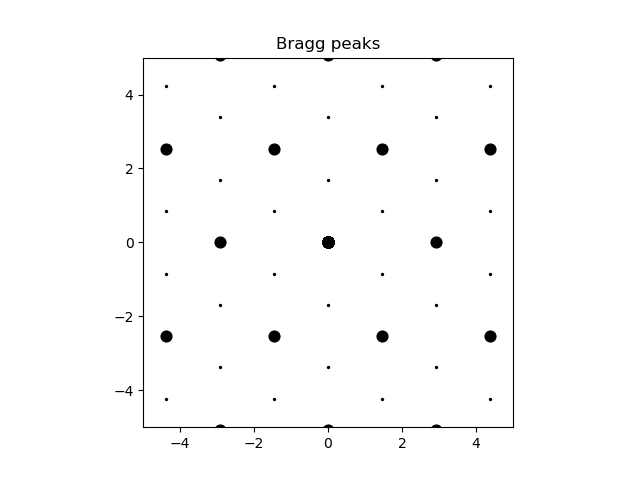

Text(0.5, 1.0, 'Bragg peaks')

In [17]:
##Plot Bragg peaks

fig1, ax1 = plt.subplots()

ax1.scatter(x_int, y_int, s = 2, color = 'k') #all reciprocal lattice vectors
ax1.scatter(x_int_bragg, y_int_bragg, s = 60, color = 'k') #only Bragg peaks

plt.xlim(-5,5)
plt.ylim(-5,5)

ax1.set_aspect('equal')
ax1.set_title('Bragg peaks')

In [18]:
# %%time

# h = np.random.uniform(h_i, h_f)
# k = np.random.uniform(k_i, k_f)

# F(h, k, 0, f, m, B, unit_r)

In [19]:
##Create mesh of diffuse scattering intensity data for entire scattering space

T = 300 #in units of Kelvin

mesh = 200

data = np.zeros((mesh*mesh,3))

i = 0
count = 0

for h in np.arange(h_i, h_f, (h_f-h_i)/mesh):
    for k in np.arange(k_i, k_f, (k_f-k_i)/mesh):
        
        count+=1 #For progress bar
        
        data[i] = [Q(h, k, 0)[0], Q(h, k, 0)[1], 0] 
#         data[i,2] = (n(h, k, 0) + 0.5)*div((np.abs(F(h, k, 0, f, m, B, unit_r)))**2, w(h, k, 0))
        data[i,2] = np.abs(F(h, k, 0, f, m, B, unit_r))

        i = i + 1
        if np.mod(count,2000) == 0:
            print(count/mesh**2)

x = data[:,0]
y = data[:,1]
z = data[:,2]

0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0


<IPython.core.display.Javascript object>


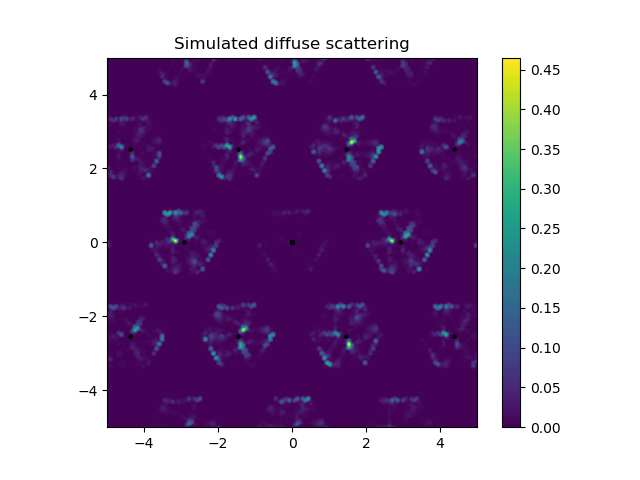

Text(0.5, 1.0, 'Simulated diffuse scattering')

In [20]:
##Plot total intensity

fig2, ax2 = plt.subplots()

tcf = ax2.tricontourf(x, y, z, vmin = 0, levels = 100)
plt.colorbar(tcf)

#tcf.set_clim(0, 15)

plt.xlim(-5,5)
plt.ylim(-5,5)

##Plot Bragg peaks

ax2.scatter(x_int_bragg, y_int_bragg, s = 5, color = 'k')

ax2.set_aspect('equal')
ax2.set_title('Simulated diffuse scattering')

In [158]:
print(z)

[0. 0. 0. ... 0. 0. 0.]
